In [46]:
import torch
from model.SASRec import SASRec
from utils.utils import data_split, set_seed, load_genre_data
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_model(path:str):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SASRec(item_num=3416, hidden_dim=50, num_heads=1, num_blocks=2, device=device)
    model.load_state_dict(torch.load(path), strict=False)
    return model

In [3]:
SASRec_model = load_model('../result/2025-05-07-12-50-19/checkpoint/SASRec_best_ndcg_0.6208_ht_0.8505_epoch_200.pth')
SASRec_tag_model = load_model('../result/2025-05-07-12-50-07/checkpoint/SASRec_best_ndcg_0.5224_ht_0.7553_epoch_340.pth')

In [5]:
data_path = '../data/ml-1m/ratings_process.txt'
genre_path = '../data/ml-1m/movies_process.txt'
[user_train, user_valid, user_test, user_num, item_num] = data_split(data_path, timestamp=False)
genre_dict = load_genre_data(genre_path)

In [12]:
tag_to_id = {}

# 遍历原字典
for movie_id, multi_hot in genre_dict.items():
    for tag_index, value in enumerate(multi_hot):
        if value == 1:
            if tag_index not in tag_to_id:
                tag_to_id[tag_index] = []
            tag_to_id[tag_index].append(movie_id)

In [13]:
tag_index_to_name = {
    1: "Animation",
    2: "Children's",
    3: "Comedy",
    4: "Adventure",
    5: "Fantasy",
    6: "Romance",
    7: "Drama",
    8: "Action",
    9: "Crime",
    10: "Thriller",
    11: "Horror",
    12: "Sci-Fi",
    13: "Documentary",
    14: "War",
    15: "Musical",
    16: "Mystery",
    17: "Film-Noir",
    18: "Western"
}

# 将 tag_to_id 中的索引替换为对应的 tag 名称
tag_name_to_id = {tag_index_to_name[tag_index + 1]: movie_ids for tag_index, movie_ids in tag_to_id.items()}

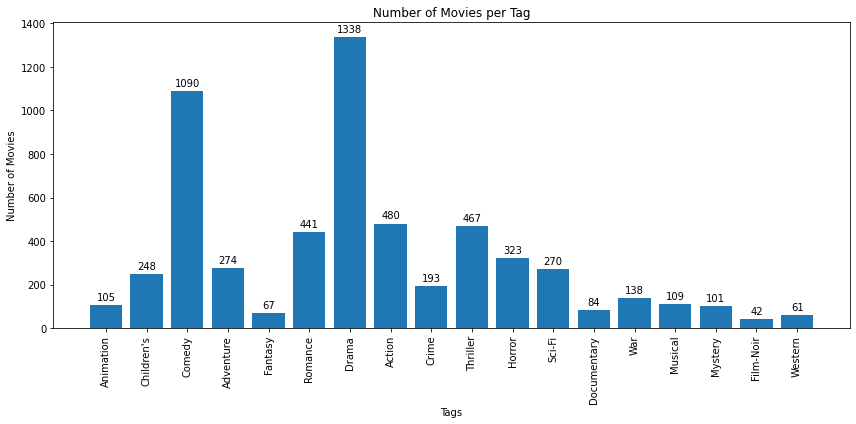

In [16]:
# 第一步，对数据进行一个简单统计
# 统计每个标签对应的电影数量
tag_counts = {tag: len(movie_ids) for tag, movie_ids in tag_name_to_id.items()}

# 提取标签名称和对应的电影数量
tags = list(tag_counts.keys())
counts = list(tag_counts.values())

# 设置图片清晰度
plt.rcParams['figure.dpi'] = 300

# 绘制直方图
plt.figure(figsize=(12, 6))
bars = plt.bar(tags, counts)

# 添加数据标签
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

# 设置图表标题和坐标轴标签
plt.title('Number of Movies per Tag')
plt.xlabel('Tags')
plt.ylabel('Number of Movies')

# 旋转 x 轴标签以避免重叠
plt.xticks(rotation=90)

# 显示图表
plt.tight_layout()
plt.show()

上图表现的是每个tag的对应电影数量，可以看出这个分布是很不均匀的，而且下面的相似性分析里面也存在随机对均值达到0.255的情况，说明有可能类似Drama类型的高频出现导致的原本不应该相关的电影也具备了相似性，引入了噪音。GPT给出了一个解决方案是使用IDF权重，削弱高频tag的影响，强化稀有tag的影响

In [17]:
# 接下来先抽样一些有共同tag的电影
# 生成所有共享至少一个tag的电影对
import itertools
import random
same_tag_pairs = []
all_items = list(genre_dict.keys())

for item1, item2 in itertools.combinations(all_items, 2):
    # 检查是否有共同tag（多热编码的按位与）
    common_tags = (genre_dict[item1] * genre_dict[item2]).sum()
    if common_tags > 0:
        same_tag_pairs.append((item1, item2))

# 如果对太多，可以随机采样N对
same_tag_pairs = random.sample(same_tag_pairs, k=1000)

In [43]:
# 生成无共同tag的随机对
random_pairs = []
while len(random_pairs) < 1000:
    item1, item2 = random.sample(all_items, 2)
    common_tags = (genre_dict[item1] * genre_dict[item2]).sum()
    if common_tags == 0:
        random_pairs.append((item1, item2))

In [58]:
def get_item_embedding(model, item_id, genre_vector=None, genre_only=False):
    id_embedding = model.item_emb.weight[item_id]
    if genre_vector is not None:
        tag_embedding = model.genre_emb(torch.tensor(genre_vector))
        embedding = model.emb_gate(id_embedding, tag_embedding)
    else:
        embedding = id_embedding
    if genre_only:
        return tag_embedding.detach()
    return embedding.detach()

In [51]:
# 接下来计算每对电影的嵌入的相似度
def get_similarity(model_old, model_new, item1, item2, genre_dict):
    model_old.eval()
    model_new.eval()
    item1_embedding_new = get_item_embedding(model_new, item1, genre_dict[item1])
    item2_embedding_new = get_item_embedding(model_new, item2, genre_dict[item2])
    item1_embedding_old = get_item_embedding(model_old, item1, None)
    item2_embedding_old = get_item_embedding(model_old, item2, None)
    similarity_new = torch.cosine_similarity(item1_embedding_new.unsqueeze(0), item2_embedding_new.unsqueeze(0))
    similarity_old = torch.cosine_similarity(item1_embedding_old.unsqueeze(0), item2_embedding_old.unsqueeze(0))
    return similarity_new, similarity_old

In [52]:
same_sim = [get_similarity(SASRec_model, SASRec_tag_model, pair[0], pair[1], genre_dict) for pair in same_tag_pairs]
random_sim = [get_similarity(SASRec_model, SASRec_tag_model, pair[0], pair[1], genre_dict) for pair in random_pairs]

In [54]:
# 首先看一下均值
same_sim_new = [sim[0].item() for sim in same_sim]
random_sim_new = [sim[0].item() for sim in random_sim]
same_sim_old = [sim[1].item() for sim in same_sim]
random_sim_old = [sim[1].item() for sim in random_sim]
print("改进后相同tag的item相似度均值:{}, 随机item的相似度均值:{}".format(np.mean(same_sim_new), np.mean(random_sim_new)))
print("改进前相同tag的item相似度均值:{}, 随机item的相似度均值:{}".format(np.mean(same_sim_old), np.mean(random_sim_old)))


改进后相同tag的item相似度均值:0.23839165318757297, 随机item的相似度均值:0.12174540444696322
改进前相同tag的item相似度均值:0.23608445373456924, 随机item的相似度均值:0.1212359679704532


从这里可以看出来实际上的改良并没有达到预期中的效果

In [60]:
# 接下来看一下如果改进后的模型没有tag信息和有tag信息和只用tag信息之间的关系
def get_similarity_2(model, item1, item2, genre_dict):
    item1_embedding_idonly = get_item_embedding(model, item1, None)
    item2_embedding_idonly = get_item_embedding(model, item2, None)
    item1_embedding_genre = get_item_embedding(model, item1, genre_dict[item1], True)
    item2_embedding_genre = get_item_embedding(model, item2, genre_dict[item2], True)
    sim_idonly = torch.cosine_similarity(item1_embedding_idonly.unsqueeze(0), item2_embedding_idonly.unsqueeze(0))
    sim_genre = torch.cosine_similarity(item1_embedding_genre.unsqueeze(0), item2_embedding_genre.unsqueeze(0))
    return sim_idonly, sim_genre

In [61]:
same_sim2 = [get_similarity_2(SASRec_tag_model, pair[0], pair[1], genre_dict) for pair in same_tag_pairs]
random_sim2 = [get_similarity_2(SASRec_tag_model, pair[0], pair[1], genre_dict) for pair in random_pairs]
same_sim2_idonly = [sim[0].item() for sim in same_sim2]
random_sim2_idonly = [sim[0].item() for sim in random_sim2]
same_sim2_tagonly = [sim[1].item() for sim in same_sim2]
random_sim2_tagonly = [sim[1].item() for sim in random_sim2]
print("仅id作用下相似tag的item的相似度均值:{}, 随机item的相似度均值:{}".format(np.mean(same_sim2_idonly), np.mean(random_sim2_idonly)))
print("仅tag作用下相似tag的item的相似度均值:{}, 随机item的相似度均值:{}".format(np.mean(same_sim2_tagonly), np.mean(random_sim2_tagonly)))

仅id作用下相似tag的item的相似度均值:0.05814437197661027, 随机item的相似度均值:0.04315973508870229
仅tag作用下相似tag的item的相似度均值:0.7633041713833809, 随机item的相似度均值:0.2551860841345042


这里发现几点：1、新加入的tag实际上是可以学习到一些隐性的相似性关系的，但是由于id_emb的权重太大导致的最后没有很好利用，也就是这个地方信息的融合方法不是很好。2、原先的没有改进的模型实际上相对这里的只用tag_emb而言还是学习到了一些相似性信息的。

In [62]:
def get_embed_norm(model, item1, genre_dict):
    item1_embedding_idonly = get_item_embedding(model, item1, None)
    item1_embedding_genre = get_item_embedding(model, item1, genre_dict[item1], True)
    norm_idonly = torch.norm(item1_embedding_idonly)
    norm_genre = torch.norm(item1_embedding_genre)
    return norm_idonly, norm_genre

In [ ]:
emb_norm = [get_embed_norm(SASRec_tag_model, pair[0], genre_dict) for pair in same_tag_pairs]
print("id embedding的均值:{}".format(np.mean([norm[0].item() for norm in emb_norm])))
print("genre embedding的均值:{}".format(np.mean([norm[1].item() for norm in emb_norm])))

id embedding的均值:1.4033988901376724
genre embedding的方差:2.847631395459175


In [74]:
# 接下来实验猜想2：改进后用户应该对历史高频tag的item更感兴趣
# 先根据历史记录进行分组
from collections import defaultdict
user_histories = user_train
tag_distribution = defaultdict(lambda: defaultdict(int))  # user_id -> {tag: count}

for user_id, items in user_histories.items():
    for item in items:
        tags = genre_dict[item]  # 当前电影的tag多热编码
        for tag_idx in tags.nonzero()[0]:
            tag_distribution[user_id][tag_idx] += 1

# 计算每个用户的类型占比
user_dominant_tags = {}
threshold = 0.3  # 高频类型阈值
for user_id, tags in tag_distribution.items():
    total = sum(tags.values())
    dominant_tags = [tag for tag, cnt in tags.items() if cnt / total >= threshold]
    if len(dominant_tags) > 0:
        user_dominant_tags[user_id] = dominant_tags


In [108]:
# 为上面的用户生成推荐列表
SASRec_tag_model.to(SASRec_tag_model.device)
SASRec_model.to(SASRec_model.device)
recom_result = {}
maxlen = 200
for u in user_dominant_tags.keys():
    SASRec_tag_model.eval()
    SASRec_model.eval()
    # 构造输入序列
    seq = np.zeros((1, maxlen), dtype=np.int32)
    idx = maxlen - 1  # 从序列的末尾开始填充
    for i in reversed(range(len(user_train[u]))):
        seq[0][idx] = user_train[u][i]
        idx -= 1
        if idx == -1:
            break  # 如果序列已经满了，就不再填充
    
    # 构建物品候选
    rated = set(user_train[u])
    rated.add(0)  # 0是填充项，需要加入候选集
    item_idx = [user_valid[u][0]]
    for _ in range(100):
        t = np.random.randint(1, item_num + 1)  # 这里numpy和random的生成不一样，numpy是左闭右开的，random是左闭右闭的
        while t in rated:
            t = np.random.randint(1, item_num + 1)        
        item_idx.append(t)  # 这里是将还未交互的物品加入候选集
        
    predicitons_old = -SASRec_model.predict((seq), (item_idx))
    
    seq_genres = np.array([genre_dict.get(i, np.zeros_like(genre_dict[1])) for i in seq[0]])
    item_genres = np.array([genre_dict.get(i, np.zeros_like(genre_dict[1])) for i in item_idx])
    seq = list(zip(seq, seq_genres))
    item_idx = list(zip(item_idx, item_genres))
    predictions_new = -SASRec_tag_model.predict((seq), (item_idx))
    
    topk = 10

    # 获取原始模型的 topk 物品索引
    topk_indices_old = predicitons_old.argsort()[0][:topk].cpu().numpy().astype(int)
    topk_items_old = [item_idx[i] if isinstance(item_idx[i], int) else item_idx[i][0] for i in topk_indices_old]

    # 获取改进模型的 topk 物品索引
    topk_indices_new = predictions_new.argsort()[0][:topk].cpu().numpy().astype(int)
    topk_items_new = [item_idx[i] if isinstance(item_idx[i], int) else item_idx[i][0] for i in topk_indices_new]

    # 将结果存入 recom_result 字典
    recom_result[u] = {
        "改进模型": topk_items_new,
        "原始模型": topk_items_old
    }

In [109]:
def get_recommendation_tag_distribution(recommended_items):
    tag_counts = defaultdict(int)
    for item in recommended_items:
        tags = genre_dict[item]
        for tag_idx in tags.nonzero()[0]:
            tag_counts[tag_idx] += 1
    total = sum(tag_counts.values())
    return {tag: cnt / total for tag, cnt in tag_counts.items()}

# 对每个用户的推荐结果计算类型分布
model_comparison = {}
for user_id in user_dominant_tags:
    # 假设rec_new和rec_old是该用户两个模型的推荐列表
    dist_new = get_recommendation_tag_distribution(recom_result[user_id]["改进模型"])
    dist_old = get_recommendation_tag_distribution(recom_result[user_id]["原始模型"])
    model_comparison[user_id] = {"改进模型": dist_new, "原始模型": dist_old}

In [110]:
# 计算WDTRG
def calculate_wdtrg(user_id, model_name, recommendation_results, user_dominant_tag):
    dominant_tag = user_dominant_tag[user_id][0]  # 可能有多个，就直接取第一个
    tag_dist = recommendation_results[user_id][model_name]
    return tag_dist.get(dominant_tag, 0.0)  # 若高频类型未出现则为0

# 计算所有用户的WDTRG均值
wdtrg_new = [
    calculate_wdtrg(user_id, "改进模型", model_comparison, user_dominant_tags)
    for user_id in user_dominant_tags
]
wdtrg_old = [
    calculate_wdtrg(user_id, "原始模型", model_comparison, user_dominant_tags)
    for user_id in user_dominant_tags
]

mean_wdtrg_new = np.mean(wdtrg_new)
mean_wdtrg_old = np.mean(wdtrg_old)
print(f"改进模型的平均WDTRG: {mean_wdtrg_new}")
print(f"原始模型的平均WDTRG: {mean_wdtrg_old}")

改进模型的平均WDTRG: 0.22721139347790165
原始模型的平均WDTRG: 0.31986949969561645


In [111]:
def calculate_dthr(recommended_items, user_dominant_tags):
    hit = 0
    for item in recommended_items:
        item_tags = genre_dict[item]
        # 检查是否有至少一个高频tag
        for tag in user_dominant_tags:
            if item_tags[tag] == 1:
                hit += 1
                break  # 避免重复计数
    return hit / len(recommended_items)

# 计算所有实验用户的平均DTHR
dthr_new = []
dthr_old = []
for user_id, data in recom_result.items():
    rec_new = data["改进模型"]
    rec_old = data["原始模型"]
    dominant_tags = user_dominant_tags[user_id]
    dthr_new.append(calculate_dthr(rec_new, dominant_tags))
    dthr_old.append(calculate_dthr(rec_old, dominant_tags))

print(f"改进模型平均DTHR: {np.mean(dthr_new):.4f}")
print(f"原始模型平均DTHR: {np.mean(dthr_old):.4f}")

改进模型平均DTHR: 0.4412
原始模型平均DTHR: 0.6046


发现性能反而变得更差了，但是这个原因就暂时还没想明白